The goal of this notebook is to extract salary data from levels.fyi and examine features of the data that are not currently accesible through the site's user interface.

In [1]:
import requests
import pandas as pd

data = requests.get('https://www.levels.fyi/js/salaryData.json').json()
df = pd.DataFrame(data)

df.head()

In [4]:
# Clean data
import numpy as np

df = df.set_index('rowNumber')
df.timestamp = pd.to_datetime(df.timestamp)

# Add NaNs where applicable in order to calculate statistics
df = df.replace('', np.nan)

# Standardize company name to remove duplicates
df.company = df.company.apply(str.lower)
df.company = df.company.apply(str.strip)

# Standardize numerical values - keep monetary values in units of thousands, all values should be floats
for col in ['totalyearlycompensation', 'basesalary', 'stockgrantvalue', 'bonus',
            'yearsofexperience', 'yearsatcompany']:
    df[col] = df[col].astype(float)
    df[col] = df[col].apply(lambda x: x/1000 if x > 1000 else x)

df.head()

,timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,tag,basesalary,stockgrantvalue,bonus,gender,otherdetails,cityid,dmaid
rowNumber,,,,,,,,,,,,,,,,
1,2017-06-07 11:33:27,oracle,L3,Product Manager,127.0,"Redwood City, CA",1.5,1.5,NaN,107.0,20.0,10.0,NaN,NaN,7392,807
2,2017-06-10 17:11:29,ebay,SE 2,Software Engineer,100.0,"San Francisco, CA",5.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,7419,807
3,2017-06-11 14:53:57,amazon,L7,Product Manager,310.0,"Seattle, WA",8.0,0.0,NaN,155.0,NaN,NaN,NaN,NaN,11527,819
5,2017-06-14 21:22:25,microsoft,64,Software Engineering Manager,200.0,"Redmond, WA",9.0,9.0,NaN,169.0,100.0,30.0,NaN,NaN,11521,819
6,2017-06-16 10:44:01,amazon,L5,Software Engineer,173.0,"Vancouver, BC, Canada",11.0,1.0,NaN,120.0,0.0,53.0,NaN,NaN,1320,0


In [5]:
# Filter for only US values, since I am interested in jobs I could potentially apply for
# International locations are listed as city, state/province, country and US locations are only city, state, 
# so remove any locations with multiple comma separators
df = df.loc[~df.location.apply(lambda x: x.count(',') > 1)]

In [6]:
# Look at only software and systems engineering, data scientist positions
similar_positions = ['Data Scientist', 'Software Engineer', 'Systems Engineer']
df = df.loc[df.title.isin(similar_positions)]

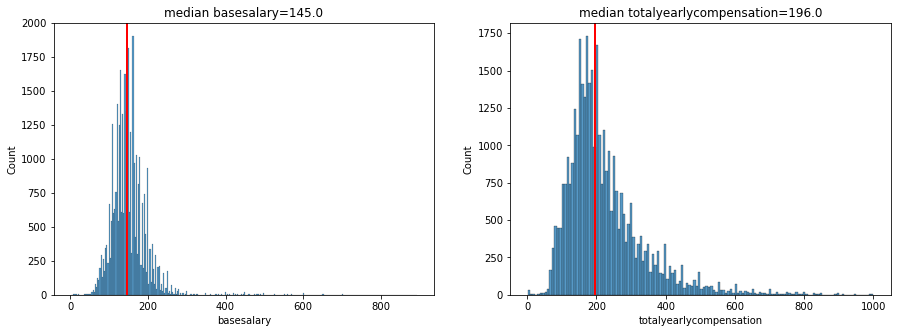

In [18]:
# Set up some histograms to see summaries of the salary data for all positions
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def median_line(ax, data):
    ymax = data.value_counts().max()
    ax.axvline(data.median(), color='red', linewidth=2)

def comphistplot(df):
    fig, ax = plt.subplots(ncols=2, figsize=(15, 5))
    for ii, column in enumerate(['basesalary', 'totalyearlycompensation']):
        sns.histplot(data=df, x=column, ax=ax[ii])
        median_line(ax[ii], df[column])
        ax[ii].set_title('median {}={}'.format(column, df[column].median()))

comphistplot(df)
#df.groupby('company')['basesalary'].median().sort_values().plot(kind='barh', ax=ax[1])

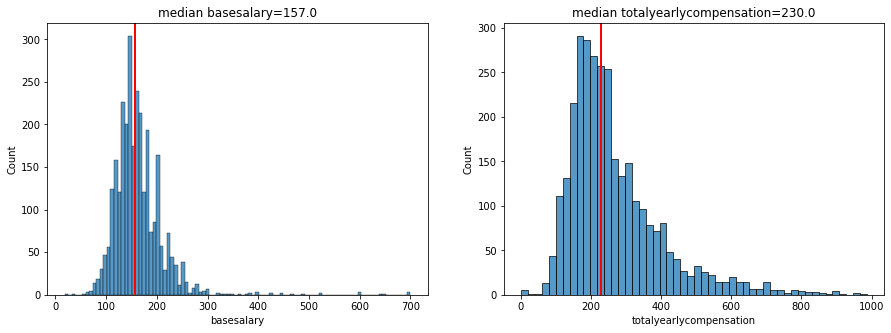

In [21]:
# Now reducing down to positions with the ML/AI tag
comphistplot(df.loc[df.tag == 'ML / AI'])


In [28]:
comp = ['basesalary', 'stockgrantvalue', 'bonus', 'totalyearlycompensation']
ml = df.tag == 'ML / AI'
df.loc[ml].groupby('company').median()[comp].sort_values('basesalary', ascending=False)[:25]

,basesalary,stockgrantvalue,bonus,totalyearlycompensation
company,,,,
netflix,495.0,18.0,0.0,467.0
roblox,262.0,130.0,0.0,348.0
roku,260.0,75.0,0.0,325.0
box,250.0,170.0,15.0,420.0
coupang,250.0,400.0,25.0,675.0
wework,245.0,120.0,30.0,380.0
dropbox,245.0,237.5,49.0,567.5
stitch fix,242.5,130.0,0.0,375.0
blackberry,240.0,10.0,10.0,260.0
